#                                         Course: Deep Learning
### Name: SAYEDPEDRAM HAERI BOROUJENI
### Instructor: Dr. Feng Luo
### Home Work: Number One
### Part 2: Optimization

## 1. Import My Packages

In [26]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transformtransforms
import torchvision.transforms.functional as TF
from torchvision import models
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import cv2
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
TORCH_CUDA_ARCH_LIST="8.6"

Project_PATH = os.path.dirname(os.path.abspath('__file__'))
outputs_dir = Project_PATH + '/Desktop/Deep Learning HW1/'
model_path = Project_PATH + '/save_models/'

## 2. My Device

In [13]:
device_default = torch.cuda.current_device()
torch.cuda.device(device_default)
device = torch.device("cuda")
print("torch.cuda.is_available:", torch.cuda.is_available())
print("torch.cuda.device_count:", torch.cuda.device_count())
print("torch.cuda.current_device:", torch.cuda.current_device())
print("torch.cuda.get_device_name:", torch.cuda.get_device_name(device_default))
print("torch.version.cuda:", torch.version.cuda)
print("torch.version:", torch.__version__)
print("torch.cuda.arch_list:", torch.cuda.get_arch_list())

torch.cuda.is_available: True
torch.cuda.device_count: 1
torch.cuda.current_device: 0
torch.cuda.get_device_name: NVIDIA RTX A5000
torch.version.cuda: 11.3
torch.version: 1.11.0
torch.cuda.arch_list: ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']


## 3. Optimization Process

In [14]:
# DNN model for MNist Dataset with 3 layers
class DNN_MNIST(nn.Module):
    def __init__(self):
        super(DNN_MNIST, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 32),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(32, 16),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(16, 10))
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        return x
    
device = torch.device("cuda")
Model_DNN_MNIST = DNN_MNIST().to(device)
summary(Model_DNN_MNIST, input_size=(1,28*28))

# CNN model for CIFAR Dataset with 6 layers
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 10, 3),nn.BatchNorm2d(10),nn.ReLU(True),nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(10, 16, 3),nn.BatchNorm2d(16),nn.ReLU(True),nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(16, 32, 3),nn.BatchNorm2d(32),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(32*4*4, 64),nn.BatchNorm1d(64),nn.ReLU(True))
        self.layer5 = nn.Sequential(nn.Linear(64, 16),nn.BatchNorm1d(16),nn.ReLU(True))
        self.layer6 = nn.Sequential(nn.Linear(16, 10))
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x) 
        x = x.view(x.size()[0], -1)
        x = self.layer4(x)    
        x = self.layer5(x)    
        x = self.layer6(x)    
        return x
    
device = torch.device("cuda")
Model = CNN_CIFAR().to(device)
summary(Model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          25,120
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
              ReLU-4                [-1, 1, 16]               0
            Linear-5                [-1, 1, 10]             170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             280
       BatchNorm2d-2           [-1, 10, 30,

## 4. Training our model 

In [16]:

def train(my_model, Epochs=20, Batch=2000, Data_workers=0, LR=0.1):

    # 1. Load our datasets
    train_data = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
    test_data = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
    train_loader = DataLoader(train_data, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    test_loader  = DataLoader(test_data,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    
    print(train_data.classes)
    print(train_data.data.shape)
    print(test_data.data.shape)
    torch.cuda.is_available()
    Model = my_model().to(device)
    Parameters = sum(param.numel() for param in Model.parameters())
    print('Number of total parameters: ', Parameters)
    
    # 2. loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)
    
    # 3. Training
    train_loss_list = []
    test_loss_list  = []
    accuracy_list  = []
    lr_list = []
    w = []
    w_prime = []
    w_loss = []
    grad_list = []
    
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        for i, data in enumerate(train_loader):
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
    # 4. Evaluation
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            total = 0
            for data in test_loader:
                images, labels = data
                images = (images.view(-1, 28*28)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
            total = len(test_loader.dataset)
            accuracy = 100.0*correct/total
    
    # 5. Save the losses values
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print('{}/{} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
                epoch, Epochs,test_loss, correct, total, accuracy))
    
    # 6. Weight collection
        if epoch % 1 == 0:
            # Layer weights
            weights_layer = np.zeros(0)
            for name,parameters in Model.named_parameters():
                if name == 'layer2.0.weight':
                    weight_i = (parameters.detach().cpu().numpy().reshape(-1))
                    weights_layer = np.concatenate((weights_layer, weight_i))
                    break
            print(weights_layer.shape)
            w_prime.append(weights_layer)
            
    # 7. Total number of weights
            weights = np.zeros(0)
            for name,parameters in Model.named_parameters():
                if name[-6:] == 'weight':
                    weight_i = (parameters.detach().cpu().numpy().reshape(-1))
                    weights = np.concatenate((weights, weight_i))
            print(weights.shape)
            w.append(weights)
            w_loss.append(train_loss)
        
    # 8. Gradient collection
        grad_all = 0.0
        for p in Model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_list.append(grad_all**0.5)
        
    return [train_loss_list,
            test_loss_list,
            accuracy_list,
            lr_list,
            w,
            w_prime,
            w_loss,
            grad_list]

## 5. Weight Collection

In [17]:
events = 8
W = []
W_loss = []
W_1 = []
G = []

for i in range(events):
    print('Event: '+str(i+1))
    [_,_,_,_,w,w_1,w_loss,grad_list] = train(DNN_MNIST)
    W.append(w)
    W_1.append(w_1)
    W_loss.append(w_loss)
    G.append(grad_list)

Event: 1
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
Number of total parameters:  25818
0/20 Test set: Average loss: 3.4754, Accuracy: 7707/10000 (77.07%)
(512,)
(25760,)
1/20 Test set: Average loss: 1.7935, Accuracy: 8948/10000 (89.48%)
(512,)
(25760,)
2/20 Test set: Average loss: 1.5520, Accuracy: 9124/10000 (91.24%)
(512,)
(25760,)
3/20 Test set: Average loss: 1.3186, Accuracy: 9225/10000 (92.25%)
(512,)
(25760,)
4/20 Test set: Average loss: 1.1891, Accuracy: 9304/10000 (93.04%)
(512,)
(25760,)
5/20 Test set: Average loss: 1.0555, Accuracy: 9369/10000 (93.69%)
(512,)
(25760,)
6/20 Test set: Average loss: 0.9739, Accuracy: 9425/10000 (94.25%)
(512,)
(25760,)
7/20 Test set: Average loss: 0.8982, Accuracy: 9463/10000 (94.63%)
(512,)
(25760,)
8/20 Test set: Average loss: 0.8590, Accuracy: 9476/10000 (94.76%)
(512,)
(25760,)
9/20 Test set: Average loss: 0.7

### 6. Dimention Reduction using PCA

In [22]:
def W_Prime_PCA(W_i):
    w = np.array(W_i)
    pca = PCA(n_components=2)
    pca.fit(w)
    w_new = pca.transform(w)
    return w_new

W1 = []
for i in range(events):
    W0 = W_Prime_PCA(W[i])
    W1.append(W0)
W1 = np.array(W1)

W2 = []
for i in range(events):
    W00 = W_Prime_PCA(W_1[i])
    W2.append(W00)
W2 = np.array(W2)

### 7. Ploting and Visualization Optimization Process

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


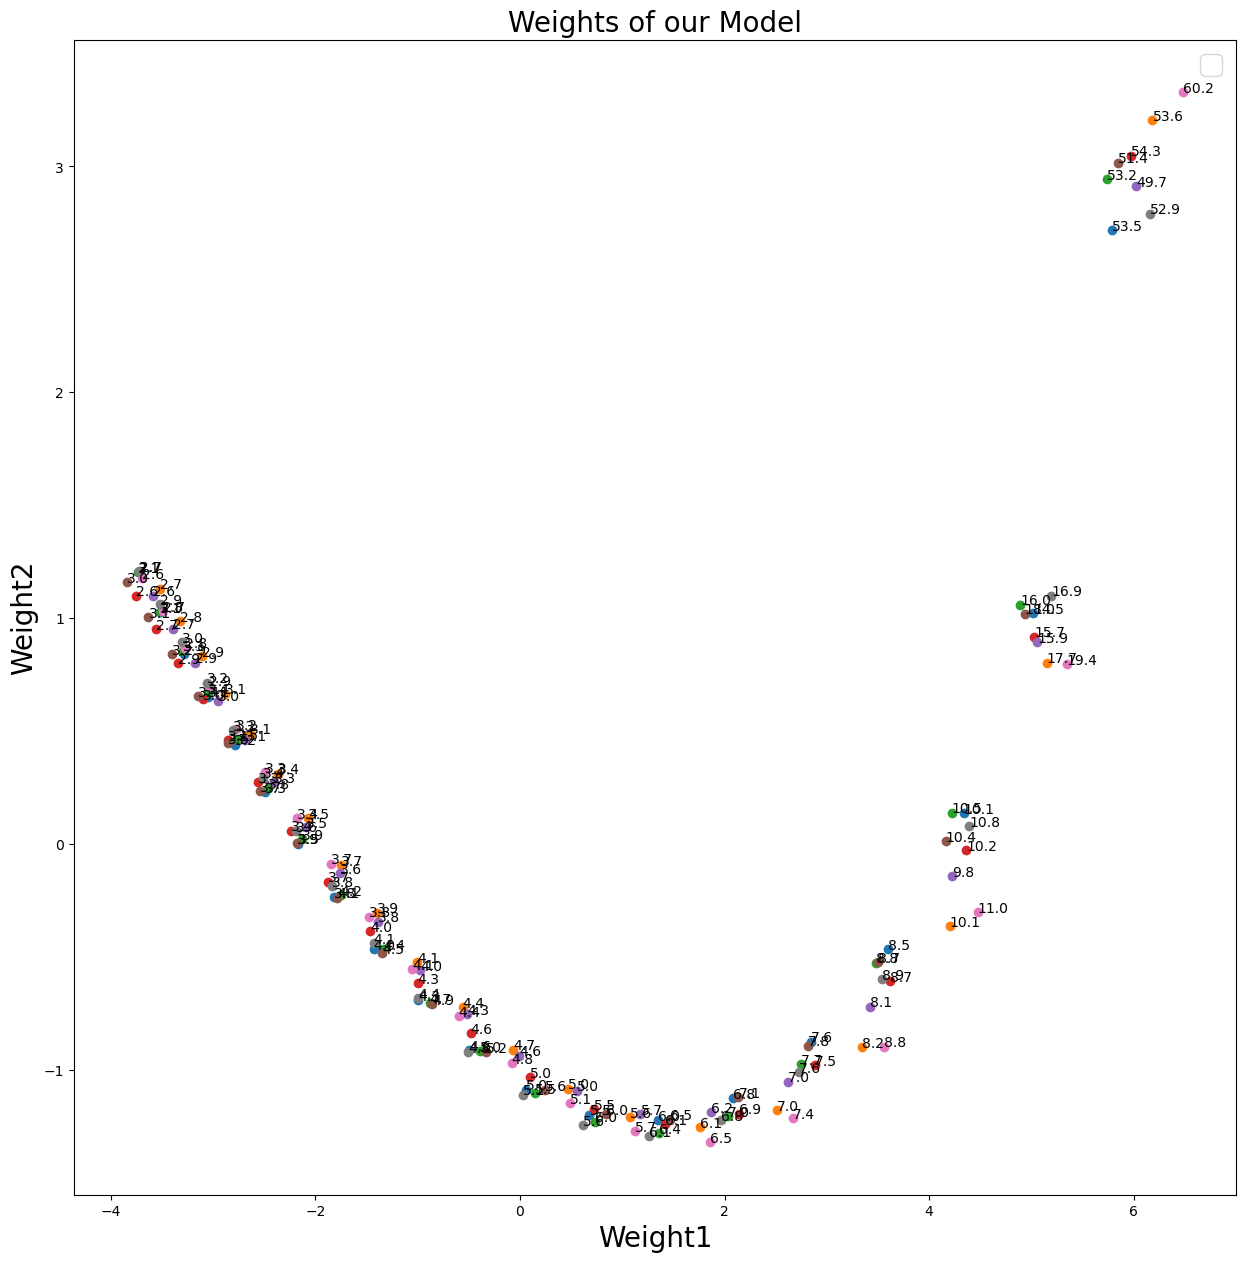

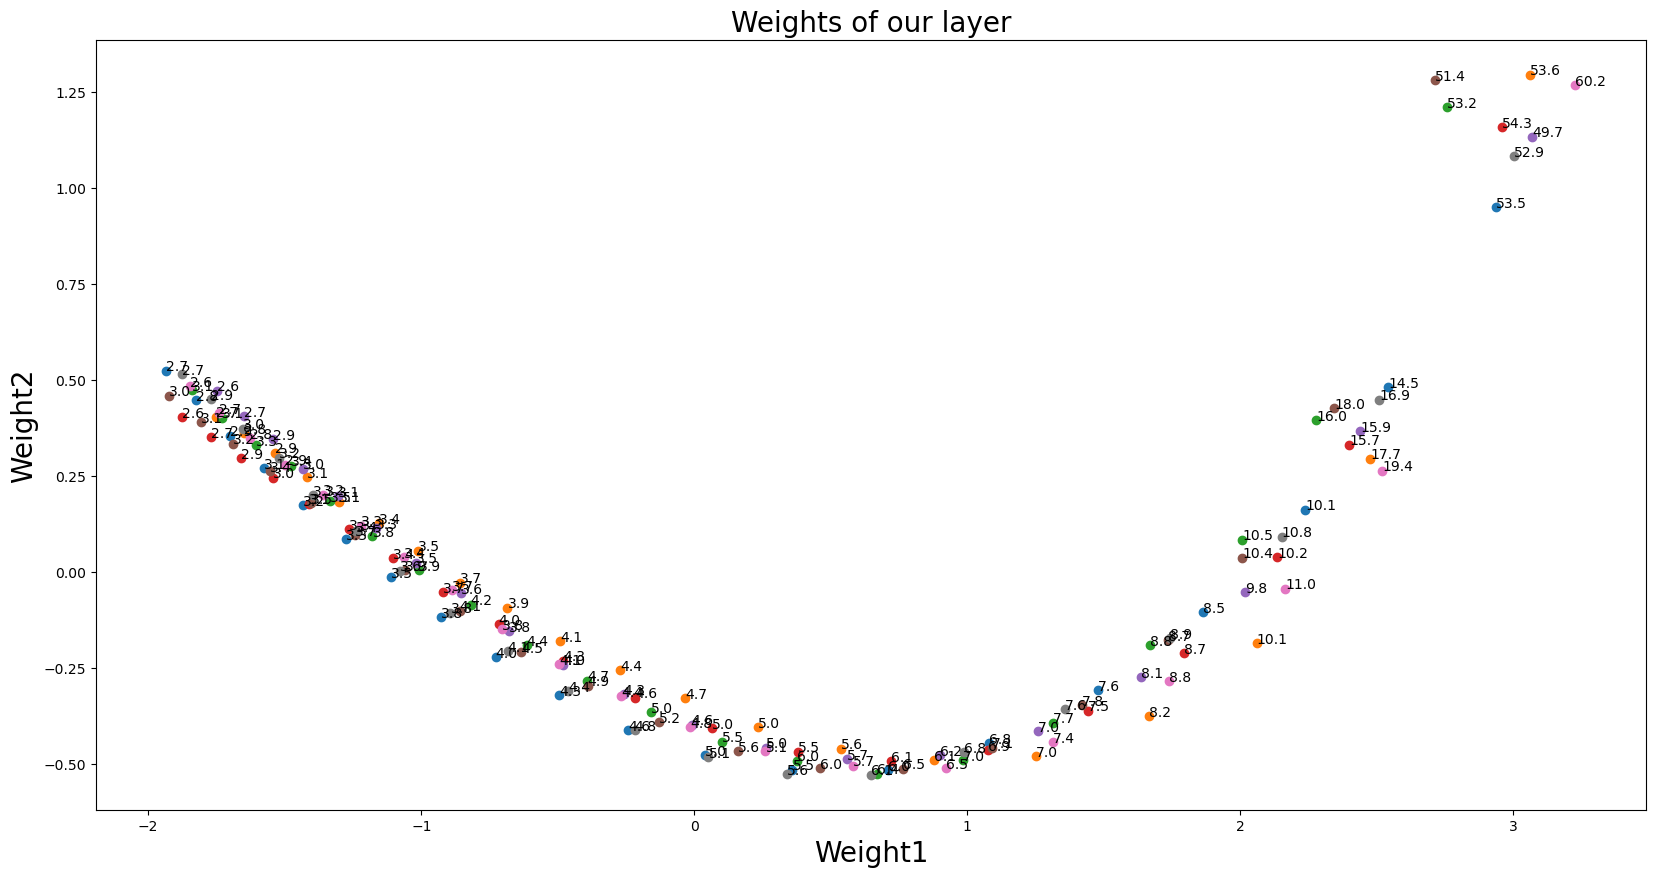

In [25]:
plt.figure(figsize=(15,15))
plt.xlabel('Weight1',fontsize=20)
plt.ylabel('Weight2',fontsize=20)
plt.title('Weights of our Model',fontsize=20)
plt.legend(fontsize=20)

for i in range(events):
    W_i = W1[i]
    plt.scatter(W_i[:,0], W_i[:,1])
    
    for j in range(len(W_i)):
        plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))
plt.show()
plt.figure(figsize=(20,10))
plt.xlabel('Weight1',fontsize=20)
plt.ylabel('Weight2',fontsize=20)
plt.title('Weights of our layer',fontsize=20)

for i in range(events):
    W_i = W2[i]
    plt.scatter(W_i[:,0], W_i[:,1])
    
    for j in range(len(W_i)):
        plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))
plt.show()

### 8. Visualization Error Surface 

C:\Users\shaerib\AppData\Local\Temp\ipykernel_13920\2546280402.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\shaerib\AppData\Local\Temp\ipykernel_13920\2546280402.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

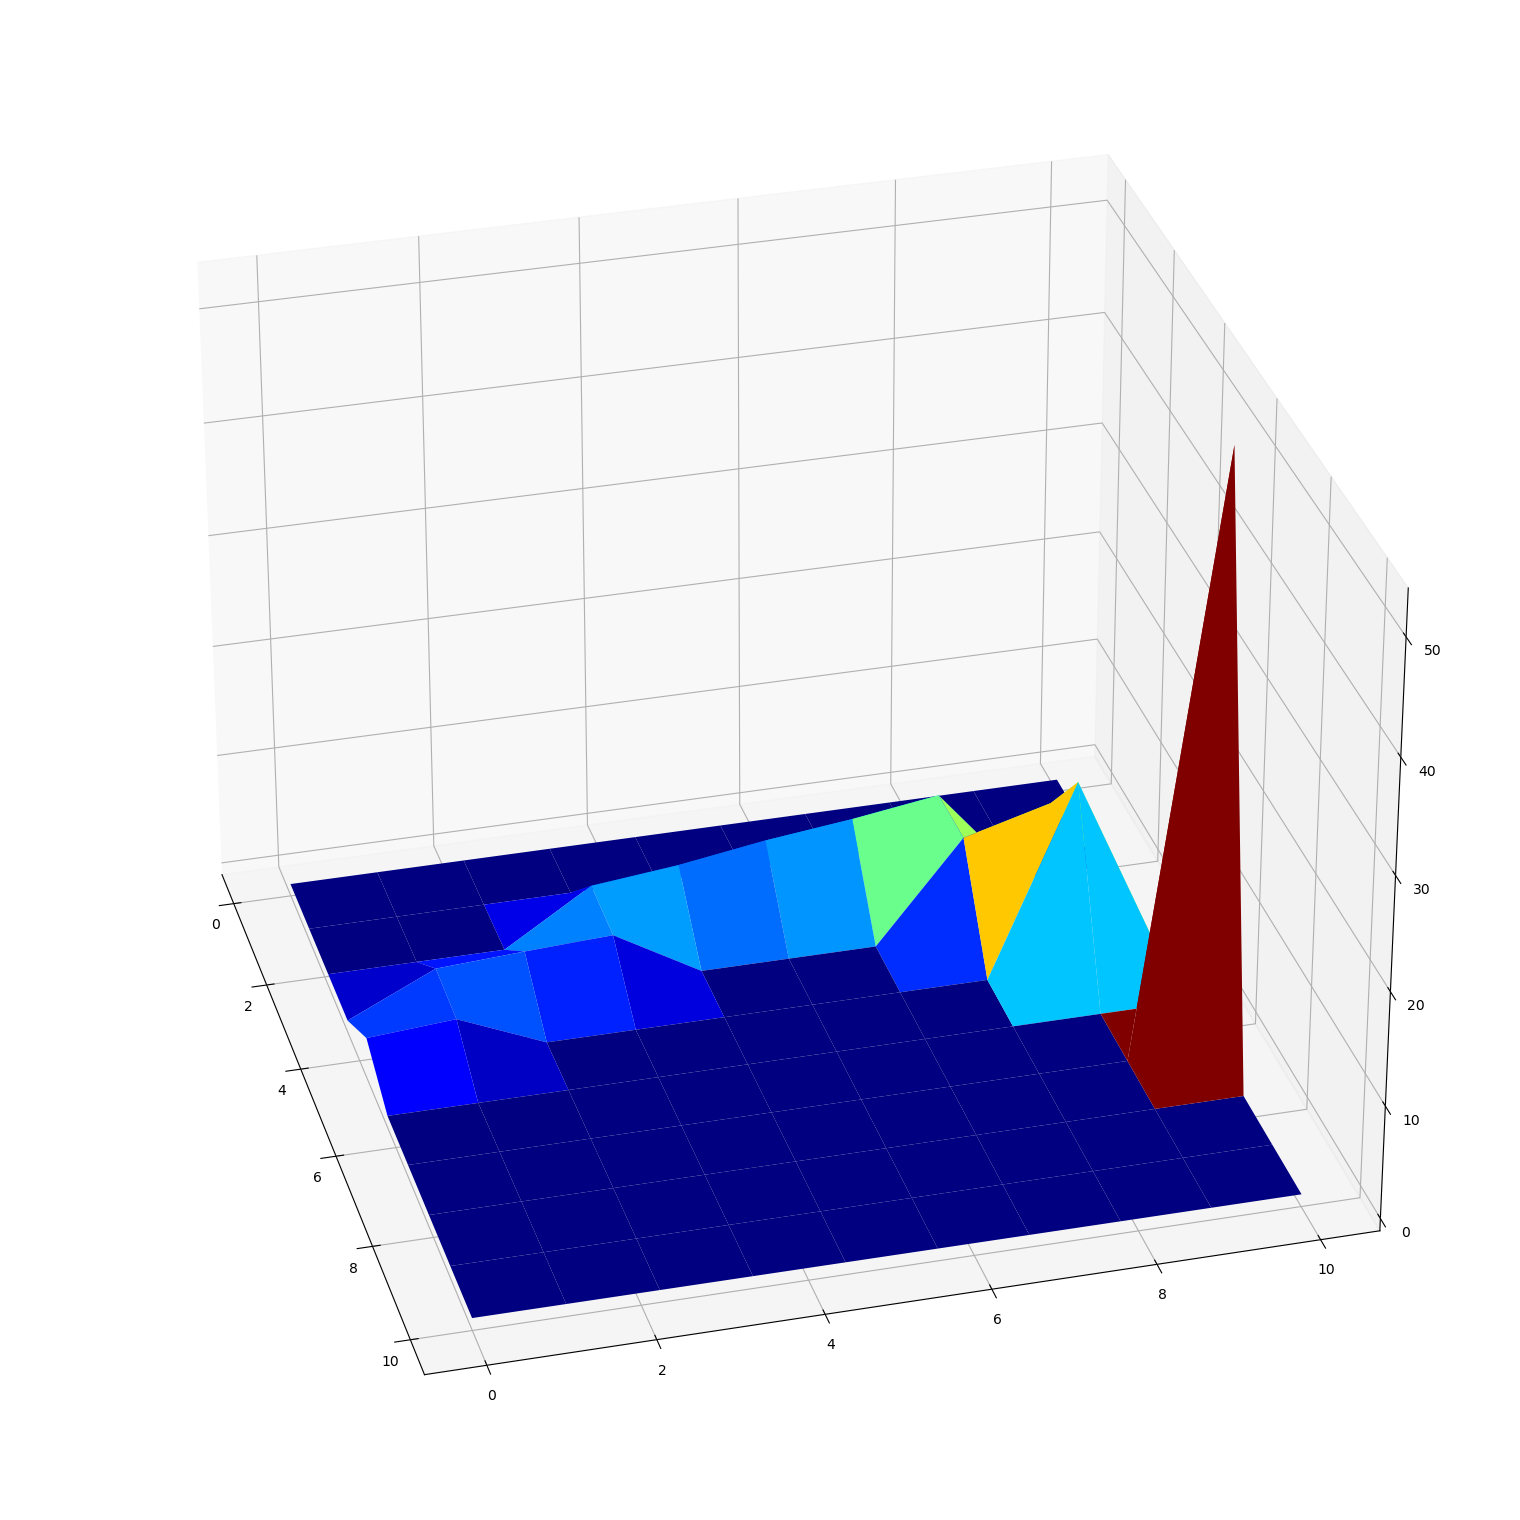

In [30]:
fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)

W_all = W1.reshape((events*len(W2[0]),2))
W_total = np.array(W_loss)
W_total = W_total.reshape(-1)

x = np.linspace(0,10,10)
y = np.linspace(0,10,10)
X, Y = np.meshgrid(x, y)
z = X-X

error = (W_all-np.min(W_all))/(np.max(W_all)-np.min(W_all))
error[error==1] = 0.99

for i in range(len(error[:,0])):
    zx = ((error[i,0])*10).astype(np.int)
    zy = ((error[i,1])*10).astype(np.int)
    z[zx,zy] = W_total[i]
    
ax.plot_surface(X, Y, z, cmap='jet')
ax.view_init(elev=30, azim=-15)
plt.show()

### 9. Observe Gradient Norm During Training

In [31]:
class DNN_MNIST_3L(nn.Module):
    def __init__(self):
        super(DNN_MNIST_3L, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 32),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(32, 16),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(16, 1))
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        return x

device = torch.device("cuda")
Model = DNN_MNIST_3L().to(device)
summary(Model, (1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]              64
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [36]:
# 1. Initialization
x = torch.linspace(0,1,1000).unsqueeze(1)
y = torch.sin(5*np.pi*x)/(5*np.pi*x)
y[0] = y[1]
function1 = y


# 2. Define train function
def train(function,
          model_name,
          Epochs = 20000,
          Batch  = 1000,
          Data_workers = 0,
          LR = 0.0005):

# 3. Initialization model
    torch.cuda.is_available()
    Model = model_name().to(device)
    x = torch.linspace(0,1,1000).unsqueeze(1)
    x = x.to(device)
    y = function.to(device)
    
# 4. loss & optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(Model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.8)

# 5. Training
    train_loss_list = []
    lr_list = []
    grad_list = []
    
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        y_pred = Model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_loss_list.append(train_loss)

        if epoch % (Epochs//10) == 0:
            print('{}/{}, loss: {}'.format(epoch,Epochs,train_loss))
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        
# 6. Grad collect
        grad_all = 0.0
        for p in Model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_list.append(grad_all**0.5)
            
    return [Model,train_loss_list,lr_list,grad_list]

In [37]:
[Model,trainloss,lr,grad_list] = train(function1, DNN_MNIST_3L, Epochs=20000, Batch=1000, Data_workers=0, LR=0.005)

0/20000, loss: 0.10970278084278107
2000/20000, loss: 7.86061937105842e-05
4000/20000, loss: 8.000803063623607e-05
6000/20000, loss: 6.482381286332384e-05
8000/20000, loss: 9.42010447033681e-05
10000/20000, loss: 5.641512689180672e-05
12000/20000, loss: 4.644765067496337e-05
14000/20000, loss: 3.641786679509096e-05
16000/20000, loss: 0.00015428826736751944
18000/20000, loss: 3.202572406735271e-05


### 10. Plotting the gradient norm and the loss 

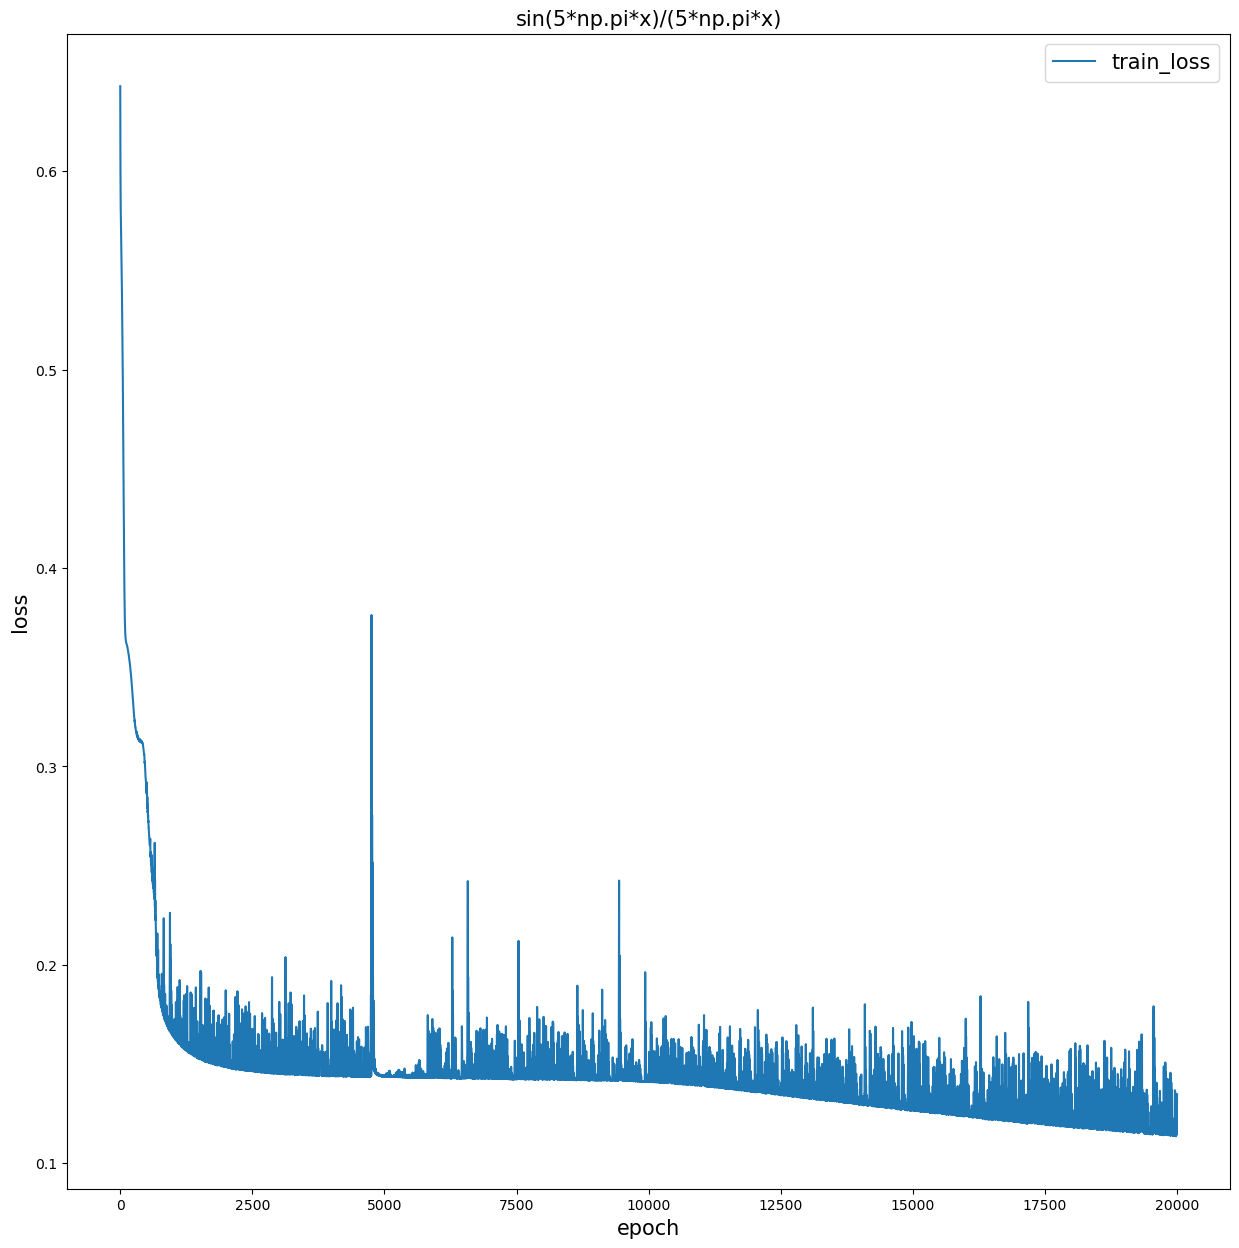

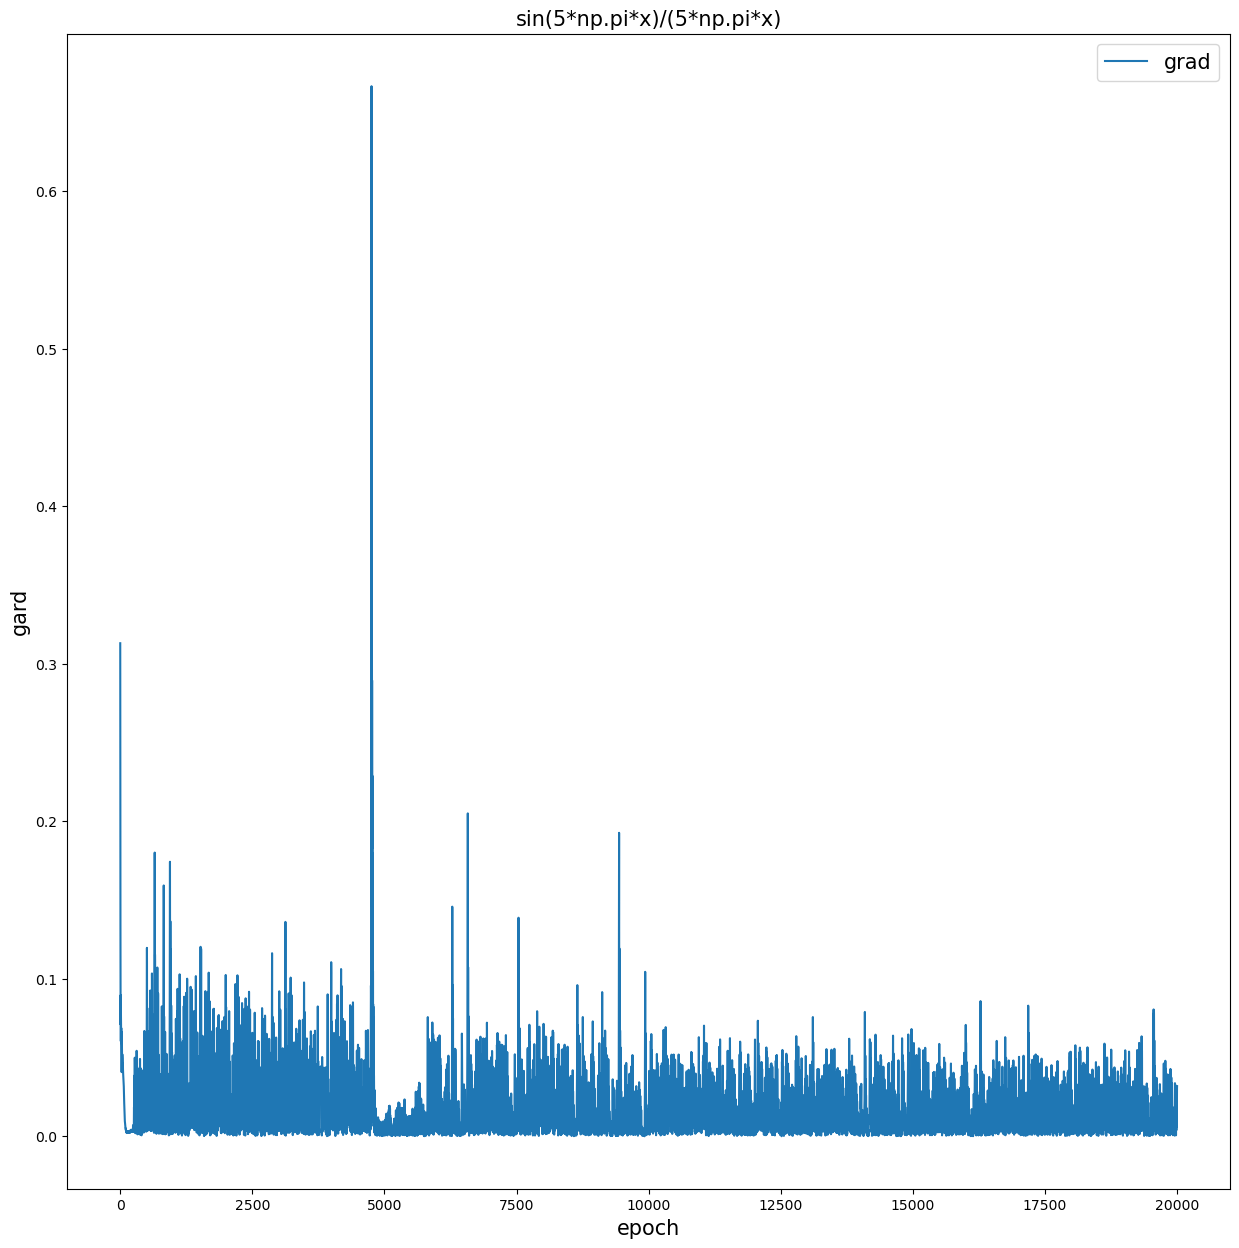

In [38]:
plt.figure(figsize=(15,15))
plt.plot(np.array(trainloss)**0.2, label='train_loss')
plt.xlabel('epoch',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('sin(5*np.pi*x)/(5*np.pi*x)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(15,15))
plt.plot(np.array(grad_list)**1, label='grad')
plt.xlabel('epoch',fontsize=15)
plt.ylabel('gard',fontsize=15)
plt.title('sin(5*np.pi*x)/(5*np.pi*x)',fontsize=15)
plt.legend(fontsize=15)
plt.show()